# Stock Trading Agents

### Dependencies

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from collections import deque
from collections import defaultdict
import yfinance as yf
import tqdm
import gym
from gym import spaces
import copy


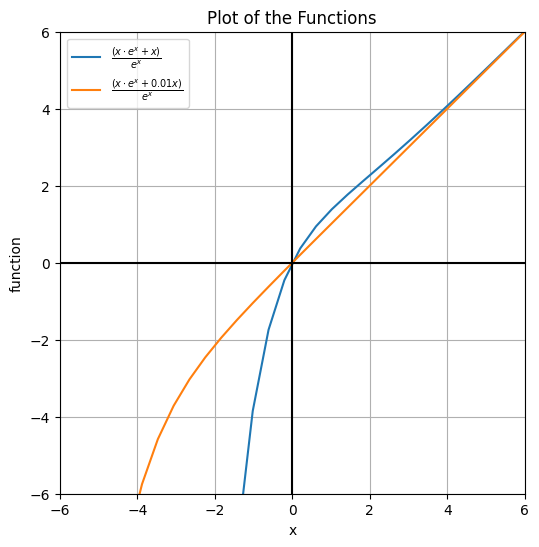

In [ ]:
# First, import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np

# Define the function to be plotted
def g(x):
    return (x*np.exp(x) + 0.01*x) / np.exp(x)

def function(x):
    # This function simplifies to x + 0.01 as e^x cancels out in the numerator and denominator
    return (x*np.exp(x) + x) / np.exp(x)

# Generate a range of x values from -2 to 2, with 400 points in between
x = np.linspace(-10, 10, 50)

# Compute the y values by applying the function to the x values
y = function(x)
z = g(x)

# Create a plot using matplotlib
plt.figure(figsize=(6, 6))  # Set the size of the plot
plt.plot(x, y, label=r'$\frac{(x \cdot e^x + x)}{e^x}$')  # Plot x against y
plt.plot(x, z, label=r'$\frac{(x \cdot e^x + 0.01x)}{e^x}$')  # Plot x against y
plt.ylim(-6, 6)
plt.xlim(-6, 6)
plt.title('Plot of the Functions')  # Add a title
plt.xlabel('x')  # Label the x-axis
plt.ylabel('function')  # Label the y-axis
plt.legend()  # Add a legend to identify the plotted line
plt.axhline(y=0, color='black')  # Add a horizontal line at y=0
plt.axvline(x=0, color='black')  # Add a vertical line at x=0
plt.grid(True)  # Turn on the grid for easier readability
plt.show()  # Display the plot


In [ ]:
import seaborn as sns

def plot(logs, x_key, y_key, legend_key, **kwargs):
    nums = len(logs[legend_key].unique())
    palette = sns.color_palette("hls", nums)
    if 'palette' not in kwargs:
        kwargs['palette'] = palette
    sns.lineplot(x=x_key, y=y_key, data=logs, hue=legend_key, **kwargs)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Trading Env

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
data_dir = '/content/drive/MyDrive/MIT-Education/Sophomore Year/6.8200/Sensorimotor Project/'


Mounted at /content/drive/


In [ ]:
def get_data(stock_symbol, start_date='1980-12-12', end_date="2024-03-01"):
    inflation = pd.read_csv(data_dir + 'CPIAUCNS.csv')
    inflation['Date'] = pd.to_datetime(inflation['DATE']).dt.to_period('M').dt.to_timestamp()
    inflation['CPI_Multiplier'] = inflation['CPIAUCNS'].iloc[-1] / inflation['CPIAUCNS']
    inflation['Date'] = pd.to_datetime(inflation['Date'])
    inflation.set_index('Date', inplace=True)
    inflation = inflation.resample('D').ffill()
    inflation = inflation.reset_index()
    inflation = inflation[(inflation['Date'] >= start_date) & (inflation['Date'] <= end_date)]
    inflation.tail()


    df = yf.download(stock_symbol, start=start_date, end=end_date)
    df = pd.merge(df, inflation, how='left', on='Date')
    df['CPI_Adjusted_Price'] = df['Adj Close'] * df['CPI_Multiplier']
    return df

get_data('AAPL').head(20)

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,DATE,CPIAUCNS,CPI_Multiplier,CPI_Adjusted_Price
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099192,469033600,1980-12-01,86.3,3.619143,0.358990
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094017,175884800,1980-12-01,86.3,3.619143,0.340262
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087117,105728000,1980-12-01,86.3,3.619143,0.315287
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089273,86441600,1980-12-01,86.3,3.619143,0.323091
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.091861,73449600,1980-12-01,86.3,3.619143,0.332458
5,1980-12-19,0.126116,0.126674,0.126116,0.126116,0.097467,48630400,1980-12-01,86.3,3.619143,0.352747
6,1980-12-22,0.132254,0.132813,0.132254,0.132254,0.102211,37363200,1980-12-01,86.3,3.619143,0.369916
7,1980-12-23,0.137835,0.138393,0.137835,0.137835,0.106524,46950400,1980-12-01,86.3,3.619143,0.385526
8,1980-12-24,0.145089,0.145647,0.145089,0.145089,0.112130,48003200,1980-12-01,86.3,3.619143,0.405815
9,1980-12-26,0.158482,0.159040,0.158482,0.158482,0.122481,55574400,1980-12-01,86.3,3.619143,0.443275


[*********************100%%**********************]  1 of 1 completed


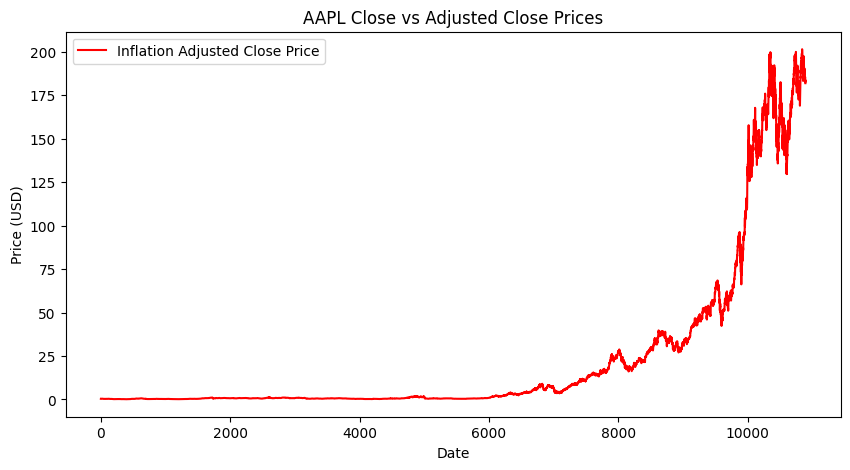

In [ ]:
df = get_data('AAPL')
# Plotting both Close and Adjusted Close prices
plt.figure(figsize=(10, 5))
#plt.plot(df.index, df['Close'], label='Close Price', color='blue')
# plt.plot(df.index, df['Adj Close'], label='Adjusted Close Price', color='green')
plt.plot(df.index, df['CPI_Adjusted_Price'], label='Inflation Adjusted Close Price', color='red')


# Adding titles and labels
plt.title('AAPL Close vs Adjusted Close Prices')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()

# Display the plot
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class StockTradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, stock_symbol, start_date="2010-01-01", end_date="2020-01-01", window_size=10):
        super(StockTradingEnv, self).__init__()
        self.stock_symbol = stock_symbol
        self.window_size = window_size
        self.data = self.download_stock_data(start=start_date, end=end_date)
        self.action_space = spaces.Discrete(3)  # 0: Buy, 1: Hold, 2: Sell
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(window_size+1,))

        self.transaction_cost_pct = 0.001
        self.holding_cost_pct = 0.0025

        self.reset()

    def download_stock_data(self, start, end):
        df = get_data(self.stock_symbol, start_date=start, end_date=end)
        return df['CPI_Adjusted_Price'].values

    def reset(self):
        self.current_step = 0
        self.holdings = 0
        self.initial_price = self.data[self.current_step]
        self.total_asset = 0
        self.initial_total_asset = 0
        self.cash_held = 0
        self.peak_asset = self.initial_total_asset
        return np.array(self.data[self.current_step:self.current_step+self.window_size].tolist() + [self.holdings])

    def calculate_reward(self, profit):
        # if profit < 0:
        #     reward = 2 * profit
        # else:
        #     reward = profit
        reward = (profit*np.exp(profit) + 0.01*profit) / np.exp(profit)
        return reward


    def step(self, action):
      self.current_step += 1
      done = self.current_step + self.window_size >= len(self.data)
      current_price = self.data[self.current_step]
      future_price = self.data[self.current_step+1] if not done else current_price
      reward = 0

      if action == 0:  # Buy
          if self.holdings == 0:
            self.initial_price = current_price
          self.holdings += 1
          self.cash_held -= current_price
          profit = future_price - current_price
          # reward += (profit*np.exp(profit) + profit) / np.exp(profit)
          reward += self.calculate_reward(profit)

      elif action == 2:  # Sell
          self.holdings -= 1
          self.cash_held += current_price
          profit = current_price - future_price
          reward += self.calculate_reward(profit)
          # reward += (profit*np.exp(profit) + profit) / np.exp(profit)

      # Apply holding cost if still holding a position
      if self.holdings != 0:
          holding_cost = current_price * self.holding_cost_pct * abs(self.holdings)
          reward -= holding_cost

      # Incorporate risk adjustment by penalizing drawdowns
      self.total_asset = self.cash_held + self.holdings * current_price
      self.peak_asset = max(self.peak_asset, self.total_asset)
      if self.peak_asset > 0:
          drawdown = (self.peak_asset - self.total_asset) / self.peak_asset
      else:
          drawdown = 0

      risk_penalty = drawdown * 0.0075
      reward -= risk_penalty

      next_state = np.array(self.data[self.current_step:self.current_step+self.window_size].tolist() + [self.holdings])
      return next_state, reward, done


    def render(self, mode='human'):
        # Placeholder for rendering the environment's behavior
        pass


## DQN

In [ ]:

# Define the DQN Model
class DQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        return self.fc(x)

# Define the Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = []
        self.capacity = capacity
        self.cur_pos = 0

    def __len__(self):
        return len(self.buffer)

    def __getitem__(self, idx):
        return self.buffer[idx]

    def add(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        if len(self.buffer) < self.capacity:
            self.buffer.append(data)
        else:
            self.buffer[self.cur_pos] = data
            self.cur_pos = (self.cur_pos + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.buffer, min(len(self.buffer), batch_size))




In [ ]:
class DQNAgent:
    def __init__(self, state_dim, action_dim, learning_rate, gamma, memory_size, update_target_every, batch_size):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.memory_size = memory_size
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.batch_size = batch_size
        self.target_update_freq = update_target_every

        self.reset()

    def reset(self):
        self.memory = ReplayBuffer(self.memory_size)  # Ensure this class is defined and implemented appropriately
        self.model = DQNetwork(self.state_dim, self.action_dim).to(self.device)
        self.target_model = DQNetwork(self.state_dim, self.action_dim).to(self.device).eval()
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.SmoothL1Loss()
        self.tau = 0.005
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_dec = 0.995
        self.epsilon_reduce = (self.epsilon - self.epsilon_min) / 2000000

    @torch.no_grad()
    def predict(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        q_values = self.model(state)
        return dict(zip(range(self.action_dim), q_values[0].cpu().numpy()))

    @torch.no_grad()
    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        q_values = self.model(state)
        if random.random() < self.epsilon:
            return random.randint(0,  q_values.size(1)- 1)
        else:
            return torch.argmax(q_values).item()

    def epsilon_decay(self):
        self.epsilon = max(self.epsilon_min, self.epsilon - self.epsilon_reduce)

    def update(self):
        if len(self.memory) < self.batch_size:
            return
        batch = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*batch)

        batch_state = torch.FloatTensor(batch_state).to(self.device)
        batch_next_state = torch.FloatTensor(batch_next_state).to(self.device)
        batch_action = torch.LongTensor(batch_action).unsqueeze(1).to(self.device)
        batch_reward = torch.FloatTensor(batch_reward).unsqueeze(1).to(self.device)
        batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(self.device)

        current_q = self.model(batch_state).gather(1, batch_action)
        with torch.no_grad():
            next_q = self.target_model(batch_next_state).max(1, keepdim=True)[0]
        expected_q = batch_reward + (1 - batch_done) * self.gamma * next_q

        loss = self.loss_fn(current_q, expected_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_qnet(self, step, soft=True):
          if not soft:
             if step % self.target_update_freq == 0:
                self.target_model.load_state_dict(self.model.state_dict())
          else:
              for target_param, param in zip(self.target_model.parameters(), self.model.parameters()):
                  target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)




In [ ]:
class DQNTrain:
    def __init__(self, env, agent):
        self.env = env
        self.agent = agent
    def train(self, num_episodes):
            results = []
            for episode in range(num_episodes):
                state = env.reset()
                total_reward = 0
                done = False
                step = 0
                while not done:
                    action = self.agent.get_action(state)
                    next_state, reward, done = self.env.step(action)
                    self.agent.memory.add(state, action, reward, next_state, done)
                    self.agent.update()
                    state = next_state
                    total_reward += reward
                    step += 1
                    self.agent.epsilon_decay()
                    self.agent.update_target_qnet(step, soft=True)


                results.append(total_reward)
                print(f"Episode: {episode+1}, Reward: {total_reward}, Epsilon: {self.agent.epsilon}, Num Steps: {step}")
            return results

In [ ]:
# Training configuration
num_episodes = 100
batch_size = 32
epsilon_decay = 0.995

# Create the environment
env = StockTradingEnv('AAPL', window_size=10)
env.reset()
# Create the agent
print(f"state dim {env.observation_space.shape[0]}")
dqn_agent = DQNAgent(env.observation_space.shape[0], env.action_space.n, 0.005, 0.99, 200000, update_target_every=100, batch_size=batch_size)


# Train the agent
dqn_train = DQNTrain(env, dqn_agent)
episode_rewards_dqn = dqn_train.train(num_episodes)

env.close()

[*********************100%%**********************]  1 of 1 completed


state dim 11
Episode: 1, Reward: -8050.961277213687, Epsilon: 0.998872299999898, Num Steps: 2506
Episode: 2, Reward: -1432.718225408207, Epsilon: 0.997744599999796, Num Steps: 2506
Episode: 3, Reward: -5224.220255014663, Epsilon: 0.996616899999694, Num Steps: 2506
Episode: 4, Reward: -4735.680170953526, Epsilon: 0.9954891999995921, Num Steps: 2506
Episode: 5, Reward: -8125.109109791348, Epsilon: 0.9943614999994901, Num Steps: 2506
Episode: 6, Reward: -8358.337569020929, Epsilon: 0.9932337999993881, Num Steps: 2506
Episode: 7, Reward: -2770.6250249915624, Epsilon: 0.9921060999992861, Num Steps: 2506
Episode: 8, Reward: -2029.803515997298, Epsilon: 0.9909783999991841, Num Steps: 2506
Episode: 9, Reward: -11653.514563177305, Epsilon: 0.9898506999990822, Num Steps: 2506
Episode: 10, Reward: -1927.000953886059, Epsilon: 0.9887229999989802, Num Steps: 2506
Episode: 11, Reward: -8992.113535673223, Epsilon: 0.9875952999988782, Num Steps: 2506
Episode: 12, Reward: -5004.0549899854295, Epsilon: 

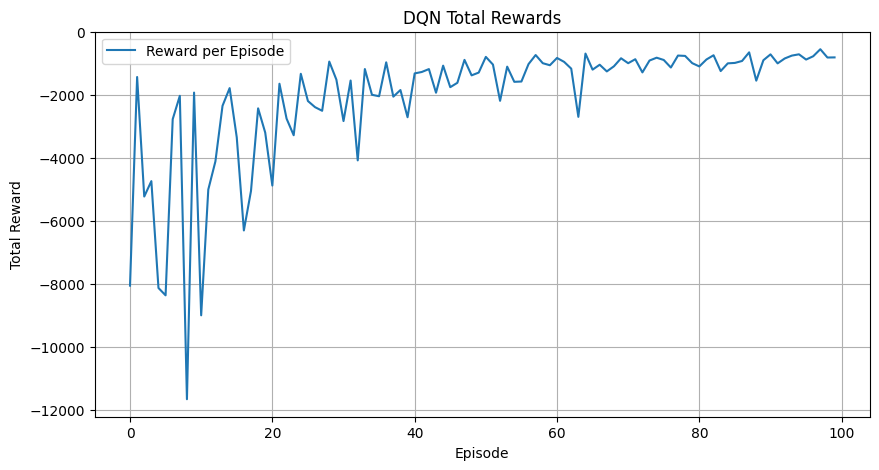

In [ ]:
# Plot the rewards
plt.figure(figsize=(10, 5))
plt.plot(episode_rewards_dqn, label='Reward per Episode')
plt.title('DQN Total Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
def test_agent(env, agent, num_episodes=10):
    state = env.reset()
    done = False
    total_rewards = []
    assets = [env.total_asset]
    while not done:
        action = agent.get_action(state)  # This uses the low epsilon to exploit the learned policy
        # print(f"action {action}")
        state, reward, done = env.step(action)
        assets.append(env.total_asset)
        total_rewards.append(reward)
    return total_rewards, assets

# Test the agent
dqn_agent.epsilon = 0
test_env = StockTradingEnv('AAPL', start_date="2021-01-01", end_date="2024-03-01", window_size=10)
test_rewards, dqn_assets = test_agent(test_env, dqn_agent, num_episodes=10)


[*********************100%%**********************]  1 of 1 completed


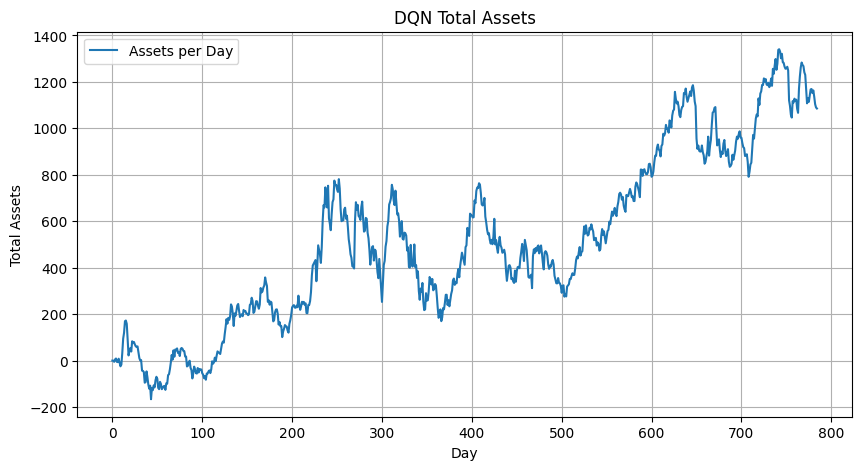

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(dqn_assets, label='Assets per Day')
plt.title('DQN Total Assets')
plt.xlabel('Day')
plt.ylabel('Total Assets')
plt.grid(True)
plt.legend()
plt.show()

## DDPG

In [ ]:


class ActorDDPG(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorDDPG, self).__init__()
        self.layer1 = nn.Linear(state_dim, 400)  # Adjusted to state_dim
        self.layer2 = nn.Linear(400, 300)
        self.layer3 = nn.Linear(300, action_dim)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.tanh(self.layer3(x))
        return x

class CriticDDPG(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(CriticDDPG, self).__init__()
        self.layer1 = nn.Linear(state_dim + 1, 400)  # Adjusted to state_dim + action_dim
        self.layer2 = nn.Linear(400, 300)
        self.layer3 = nn.Linear(300, 1)

    def forward(self, x, u):
        u = u.unsqueeze(-1)
        x = torch.cat([x, u], 1)
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x


In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = []
        self.capacity = capacity
        self.cur_pos = 0

    def __len__(self):
        return len(self.buffer)

    def __getitem__(self, idx):
        return self.buffer[idx]

    def add(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        if len(self.buffer) < self.capacity:
            self.buffer.append(data)
        else:
            self.buffer[self.cur_pos] = data
            self.cur_pos = (self.cur_pos + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.buffer, min(len(self.buffer), batch_size))


In [ ]:

class DDPGAgent:
    def __init__(self, state_dim, action_dim, max_action, lr=0.001, gamma=0.99, tau=0.005, buffer_size=10000, batch_size=1000):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.max_action = max_action
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.buffer_size = buffer_size
        self.lr = lr

        self.reset()

    def reset(self):
        self.memory = ReplayBuffer(self.buffer_size)
        self.actor = ActorDDPG(self.state_dim, self.action_dim).to(self.device)
        self.actor_target = copy.deepcopy(self.actor).eval()
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=self.lr)

        self.critic = CriticDDPG(self.state_dim, self.action_dim).to(self.device)
        self.critic_target = copy.deepcopy(self.critic).eval()
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=self.lr)

        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_dec = 0.995
        self.epsilon_reduce = (self.epsilon - self.epsilon_min) / 2000000

    # @torch.no_grad()
    # def get_action(self, state, noise_scale=0.1):
    #     state = torch.FloatTensor(state.reshape(1, -1)).to(self.device)
    #     # Assuming the actor network outputs raw scores for each action
    #     action_scores = self.actor(state)
    #     # Use softmax to convert scores to probabilities and then select the action with highest probability
    #     action_probabilities = torch.softmax(action_scores, dim=1)
    #     action = torch.argmax(action_probabilities).item()
    #     return action


    @torch.no_grad()
    def get_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(0, self.action_dim-1)
        else:
            state = torch.FloatTensor(state.reshape(1, -1)).to(self.device)
            # Assuming the actor network outputs raw scores for each action
            action_scores = self.actor(state)
            # Use softmax to convert scores to probabilities and then select the action with highest probability
            action_probabilities = torch.softmax(action_scores, dim=1)
            action = torch.argmax(action_probabilities).item()
            return action
        # state = torch.FloatTensor(state.reshape(1, -1)).to(self.device)
        # action_probs = self.actor(state)
        # action_probs = torch.softmax(action_probs, dim=1)  # Convert to probabilities
        # action = torch.multinomial(action_probs, 1)  # Sample an action
        # return action.cpu().data.numpy().flatten()[0]


    def epsilon_decay(self):
        self.epsilon = max(self.epsilon_min, self.epsilon - self.epsilon_reduce)


    def update(self):
        if len(self.memory) < self.batch_size:
            return
        batch = self.memory.sample(self.batch_size)
        batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*batch)

        batch_state = torch.FloatTensor(batch_state).to(self.device)
        batch_next_state = torch.FloatTensor(batch_next_state).to(self.device)
        batch_action = torch.LongTensor(batch_action).to(self.device)
        batch_reward = torch.FloatTensor(batch_reward).to(self.device)
        batch_done = torch.FloatTensor(batch_done).to(self.device)


        # Compute the target Q value
        with torch.no_grad():
          target_actions = self.actor_target(batch_next_state).argmax(dim=1)
          target_Q = self.critic_target(batch_next_state, target_actions.float())
        target_Q = batch_reward + ((1 - batch_done) * self.gamma * target_Q)

        # Get current Q estimate
        # print(batch_state.shape, batch_action.shape)
        current_Q = self.critic(batch_state, batch_action.float())


        # Compute critic loss
        critic_loss = F.mse_loss(current_Q, target_Q)

        # Optimize the critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Compute actor loss
        actor_loss = self.critic(batch_state, self.actor(batch_state).argmax(dim=1) - 1).mean()

        # Optimize the actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()


    def update_target_qnet(self, step, soft=False):
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

    # def train(self, env, num_episodes):
    #     episode_rewards = []
    #     for episode in range(num_episodes):
    #         state = env.reset()
    #         episode_reward = 0
    #         done = False
    #         while not done:
    #             action = self.select_action(state)
    #             next_state, reward, done = env.step(action)
    #             self.replay_buffer.add(state, action, reward, next_state, done)
    #             episode_reward += reward
    #             state = next_state

    #             self.update()

    #         episode_rewards.append(episode_reward)
    #         print(f'Episode {episode + 1}/{num_episodes}, Reward: {episode_reward}')

    #     return episode_rewards

        # epislon greedy


In [ ]:
class DDPGTrain:
    def __init__(self, env, agent):
        self.env = env
        self.agent = agent
    def train(self, num_episodes):
            results = []
            for episode in range(num_episodes):
                state = env.reset()
                total_reward = 0
                done = False
                step = 0
                while not done:
                    action = self.agent.get_action(state)
                    next_state, reward, done = self.env.step(action)
                    self.agent.memory.add(state, action, reward, next_state, done)
                    self.agent.update()
                    state = next_state
                    total_reward += reward
                    step += 1
                    self.agent.epsilon_decay()
                    self.agent.update_target_qnet(step, soft=True)


                results.append(total_reward)
                print(f"Episode: {episode+1}, Reward: {total_reward}, Epsilon: {self.agent.epsilon}, Num Steps: {step}")
            return results

In [ ]:
# Training configuration
num_episodes = 100
batch_size = 64
epsilon_decay = 0.995

# Create the environment
env = StockTradingEnv('AAPL', window_size=10)
env.reset()
# Create the agent
ddpg_agent = DDPGAgent(env.observation_space.shape[0], env.action_space.n, 0.005, 0.98, 200000, batch_size=batch_size)


# Train the agent
ddpg_train = DDPGTrain(env, ddpg_agent)
episode_rewards_ddpg = ddpg_train.train(num_episodes)

env.close()

[*********************100%%**********************]  1 of 1 completed
<ipython-input-46-82d467c83fc6>:89: UserWarning: Using a target size (torch.Size([64, 64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  critic_loss = F.mse_loss(current_Q, target_Q)


Episode: 1, Reward: -159743.72331787128, Epsilon: 0.998872299999898, Num Steps: 2506
Episode: 2, Reward: -166784.8411654144, Epsilon: 0.997744599999796, Num Steps: 2506
Episode: 3, Reward: -162676.45425747454, Epsilon: 0.996616899999694, Num Steps: 2506
Episode: 4, Reward: -162315.1211498566, Epsilon: 0.9954891999995921, Num Steps: 2506
Episode: 5, Reward: -169224.0988454336, Epsilon: 0.9943614999994901, Num Steps: 2506
Episode: 6, Reward: -162596.32041515937, Epsilon: 0.9932337999993881, Num Steps: 2506
Episode: 7, Reward: -163657.73447438618, Epsilon: 0.9921060999992861, Num Steps: 2506
Episode: 8, Reward: -161706.60295136503, Epsilon: 0.9909783999991841, Num Steps: 2506
Episode: 9, Reward: -164077.73815109293, Epsilon: 0.9898506999990822, Num Steps: 2506
Episode: 10, Reward: -162445.26699474812, Epsilon: 0.9887229999989802, Num Steps: 2506
Episode: 11, Reward: -168011.97111212162, Epsilon: 0.9875952999988782, Num Steps: 2506
Episode: 12, Reward: -161446.7702730727, Epsilon: 0.986467

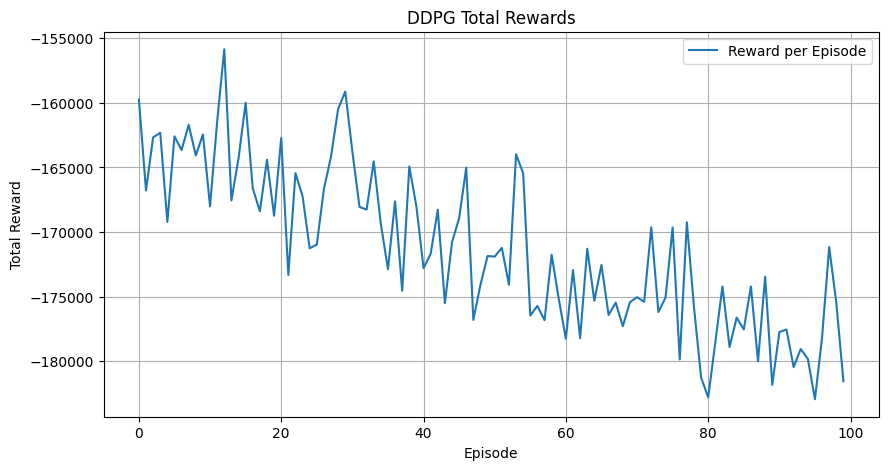

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(episode_rewards_ddpg, label='Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DDPG Total Rewards')
plt.legend()
plt.grid(True)
plt.show()


[*********************100%%**********************]  1 of 1 completed


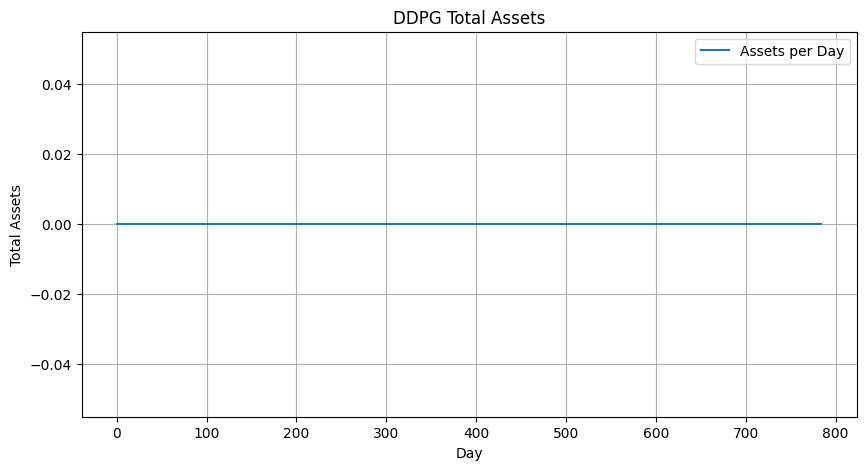

In [ ]:
def test_agent(env, agent, num_episodes=10):
    state = env.reset()
    done = False
    total_rewards = []
    assets = [env.total_asset]
    while not done:
        action = agent.get_action(state)  # This uses the low epsilon to exploit the learned policy
        #print(f"action {action}")
        state, reward, done = env.step(action)
        assets.append(env.total_asset)
        total_rewards.append(reward)
    return total_rewards, assets

# Test the agent
ddpg_agent.epsilon = 0
test_env = StockTradingEnv('AAPL', start_date="2021-01-01", end_date="2024-03-01", window_size=10)
test_rewards, ddpg_assets = test_agent(test_env, ddpg_agent, num_episodes=10)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(ddpg_assets, label='Assets per Day')
plt.title('DDPG Total Assets')
plt.xlabel('Day')
plt.ylabel('Total Assets')
plt.grid(True)
plt.legend()
plt.show()

## A2C

In [ ]:
# class ActorCritic(nn.Module):
#     def __init__(self, state_dim, action_dim):
#         super(ActorCritic, self).__init__()
#         self.actor = nn.Sequential(
#             nn.Linear(state_dim, 128),
#             nn.ReLU(),
#             nn.Linear(128, action_dim),
#             nn.Softmax(dim=-1)
#         )
#         self.critic = nn.Sequential(
#             nn.Linear(state_dim, 128),
#             nn.ReLU(),
#             nn.Linear(128, 1)
#         )

#     def forward(self, state):
#         action_probs = self.actor(state)
#         state_values = self.critic(state)
#         return action_probs, state_values


class ActorA2C(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorA2C, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.network(x)

class CriticA2C(nn.Module):
    def __init__(self, state_dim):
        super(CriticA2C, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.network(x)


In [ ]:
import torch
import numpy as np
from torch.distributions import Categorical

class A2CAgent:
    def __init__(self, state_dim, action_dim, lr_actor=0.001, lr_critic=0.001, gamma=0.99):
        self.actor = ActorA2C(state_dim, action_dim)
        self.critic = CriticA2C(state_dim)  # Critic outputs a single value
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=lr_critic)
        self.gamma = gamma

    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        probs = self.actor(state)
        dist = Categorical(probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        return action.item(), log_prob

    def compute_returns(self, next_value, rewards, masks):
        R = next_value
        returns = []
        for step in reversed(range(len(rewards))):
            R = rewards[step] + self.gamma * R * masks[step]
            returns.insert(0, R)
        return returns

    def update(self, log_probs, values, rewards, masks, next_value):
        returns = self.compute_returns(next_value, rewards, masks)

        log_probs = torch.cat(log_probs)
        returns = torch.cat(returns).detach()
        values = torch.cat(values)

        advantage = returns - values

        actor_loss = -(log_probs * advantage.detach()).mean()
        critic_loss = 0.5 * advantage.pow(2).mean()

        self.optimizer_actor.zero_grad()
        actor_loss.backward()
        self.optimizer_actor.step()

        self.optimizer_critic.zero_grad()
        critic_loss.backward()
        self.optimizer_critic.step()

    def train(self, env, num_episodes):
        episode_rewards = []
        for episode in range(num_episodes):
            state = env.reset()
            log_probs = []
            values = []
            masks = []
            rewards = []
            total_reward = 0

            done = False
            while not done:
                action, log_prob = self.get_action(state)
                next_state, reward, done = env.step(action)

                log_probs.append(log_prob)
                values.append(self.critic(torch.FloatTensor(state).unsqueeze(0)))
                rewards.append(torch.FloatTensor([reward]))
                masks.append(torch.FloatTensor([1 - done]))

                state = next_state
                total_reward += reward

            next_value = self.critic(torch.FloatTensor(state).unsqueeze(0))
            self.update(log_probs, values, rewards, masks, next_value)

            episode_rewards.append(total_reward)
            print(f"Episode {episode + 1}: Total Reward = {total_reward}")

        return episode_rewards



In [ ]:
env = StockTradingEnv('AAPL')
print(env.total_asset)
env.reset()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

batch_size = 2000

a2c_agent = A2CAgent(state_dim, action_dim)
episode_rewards_a2c = a2c_agent.train(env, num_episodes=50)

[*********************100%%**********************]  1 of 1 completed


0
Episode 1: Total Reward = -298852.1544476184
Episode 2: Total Reward = -18944.22193053358
Episode 3: Total Reward = -2819.143862509973
Episode 4: Total Reward = -1216.936525675591
Episode 5: Total Reward = -295358.09895411605
Episode 6: Total Reward = -5798.925865484197
Episode 7: Total Reward = -7243.842922347924
Episode 8: Total Reward = -4786.32046271265
Episode 9: Total Reward = -4812.404708674306
Episode 10: Total Reward = -2755.90741825545
Episode 11: Total Reward = -2266.4309514228016
Episode 12: Total Reward = -5378.968574592545
Episode 13: Total Reward = -2673.3272988387694
Episode 14: Total Reward = -636.8560796355216
Episode 15: Total Reward = -483.5011023735907
Episode 16: Total Reward = -667.4175780617145
Episode 17: Total Reward = -1030.199378527996
Episode 18: Total Reward = -1259.8160687286302
Episode 19: Total Reward = -1445.8981254446667
Episode 20: Total Reward = -1538.969898908301
Episode 21: Total Reward = -1754.3549728314038
Episode 22: Total Reward = -1887.2986

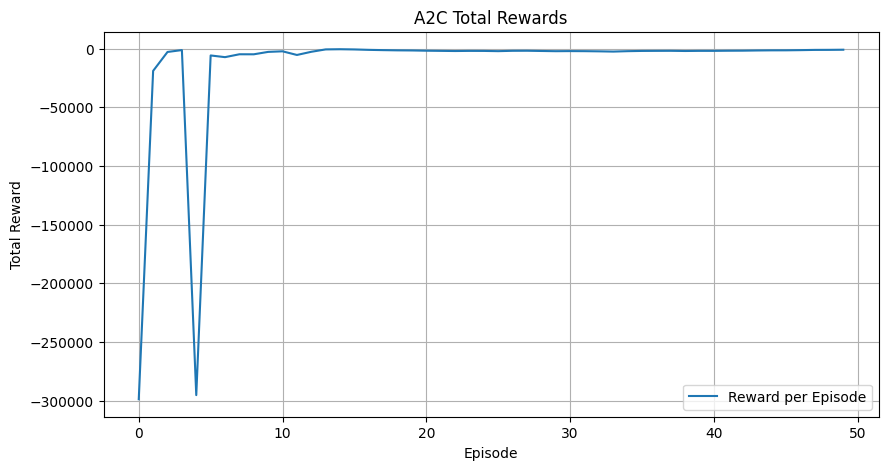

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(episode_rewards_a2c, label='Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('A2C Total Rewards')
plt.legend()
plt.grid(True)
plt.show()


[*********************100%%**********************]  1 of 1 completed


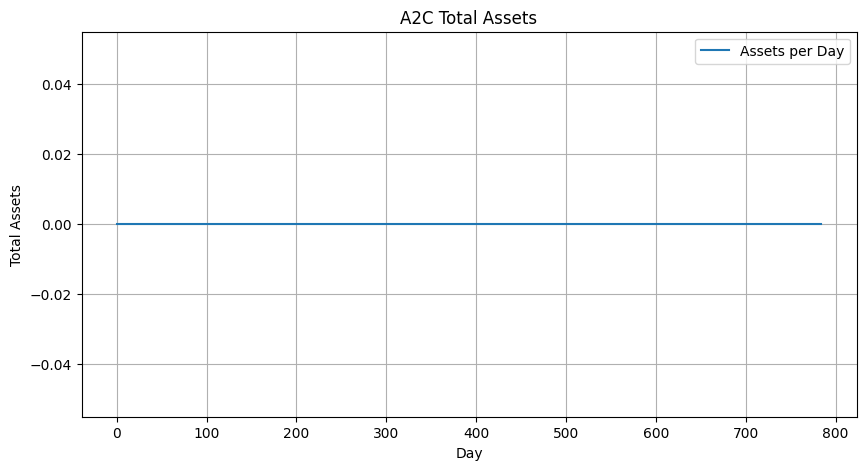

In [ ]:
def test_agent(env, agent, num_episodes=10):
    state = env.reset()
    done = False
    total_rewards = []
    assets = [env.total_asset]
    while not done:
        action = agent.get_action(state)  # This uses the low epsilon to exploit the learned policy
        # print(action[0])
        state, reward, done = env.step(action)
        assets.append(env.total_asset)
        total_rewards.append(reward)
    return total_rewards, assets

# Test the agent
a2c_agent.epsilon = 0
test_env = StockTradingEnv('AAPL', start_date="2021-01-01", end_date="2024-03-01", window_size=10)
test_rewards, a2c_assets = test_agent(test_env, a2c_agent, num_episodes=10)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(a2c_assets, label='Assets per Day')
plt.title('A2C Total Assets')
plt.xlabel('Day')
plt.ylabel('Total Assets')
plt.grid(True)
plt.legend()
plt.show()

## PPO

In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, action_dim),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        action_prob = self.actor(x)
        value = self.critic(x)
        return action_prob, value

class PolicyValueNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyValueNet, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.policy = nn.Linear(64, action_dim)
        self.value = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return torch.softmax(self.policy(x), dim=-1), self.value(x)


class ActorPPO(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorPPO, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.action_head = nn.Linear(64, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        action_probs = F.softmax(self.action_head(x), dim=-1)
        return action_probs

class CriticPPO(nn.Module):
    def __init__(self, state_dim):
        super(CriticPPO, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.value_head = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.value_head(x)
        return value



In [ ]:
class PPOAgent:
    def __init__(self, state_dim, action_dim, lr=0.002):
        self.actor = ActorPPO(state_dim, action_dim)
        self.critic = CriticPPO(state_dim)
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=lr)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=lr)

    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action_probs = self.actor(state)
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)
        value = self.critic(state)
        return action.item(), log_prob, value.squeeze()

    def compute_advantages(self, rewards, values, dones, gamma=0.99, lam=0.95):
        returns = []
        advantages = []
        gae = 0
        next_value = 0
        for step in reversed(range(len(rewards))):
            if step == len(rewards) - 1 or dones[step]:
                next_value = 0
            delta = rewards[step] + gamma * next_value - values[step]
            gae = delta + gamma * lam * gae
            next_value = values[step]
            returns.insert(0, gae + values[step])
            advantages.insert(0, gae)
        return returns, advantages

    def update(self, states, actions, old_log_probs, returns, advantages, clip_param=0.2):
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)
        old_log_probs = torch.tensor(old_log_probs, dtype=torch.float32)
        returns = torch.tensor(returns, dtype=torch.float32)
        advantages = torch.tensor(advantages, dtype=torch.float32)

        # Get new log probs and state values
        action_probs = self.actor(states)
        dists = torch.distributions.Categorical(action_probs)
        new_log_probs = dists.log_prob(actions)
        new_values = self.critic(states).squeeze(-1)

        # Calculate the ratio (pi_theta / pi_theta_old)
        ratios = torch.exp(new_log_probs - old_log_probs)

        # Calculate actor loss (PPO clipped objective)
        surr1 = ratios * advantages
        surr2 = torch.clamp(ratios, 1.0 - clip_param, 1.0 + clip_param) * advantages
        actor_loss = -torch.min(surr1, surr2).mean()

        # Calculate critic loss
        critic_loss = F.mse_loss(new_values, returns)

        # Perform backpropagation
        self.optimizer_actor.zero_grad()
        self.optimizer_critic.zero_grad()
        (actor_loss + critic_loss).backward()
        self.optimizer_actor.step()
        self.optimizer_critic.step()



In [ ]:
class PPOTrain:
    def __init__(self, env, agent):
        self.agent = agent
        self.env = env

    def train(self, epochs=75, steps_per_epoch=2048, clip_param=0.2):
        episode_rewards = []
        for epoch in range(epochs):
            states, actions, rewards, dones, old_log_probs, values = [], [], [], [], [], []
            state = self.env.reset()
            for step in range(steps_per_epoch):
                action, log_prob, value = self.agent.select_action(state)
                next_state, reward, done = self.env.step(action)

                states.append(state)
                actions.append(action)
                rewards.append(reward)
                dones.append(done)
                old_log_probs.append(log_prob.detach().numpy())
                values.append(value.detach().numpy())

                state = next_state if not done else self.env.reset()

                if done:
                    break

            episode_rewards.append(sum(rewards))

            returns, advantages = self.agent.compute_advantages(rewards, values, dones)
            self.agent.update(states, actions, old_log_probs, returns, advantages, clip_param)
            print(f"Epoch {epoch + 1}/{epochs} completed. Reward is {sum(rewards)}")

        return episode_rewards



In [ ]:
# Assuming device, ActorCritic, PPOAgent, Memory, and StockTradingEnv are defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the environment
env = StockTradingEnv('AAPL')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Initialize the PPO Agent and memory
ppo_agent = PPOAgent(state_dim, action_dim)

# Initialize the PPO Trainer
ppo_train = PPOTrain(env, ppo_agent)

# Start training
episode_rewards_ppo = ppo_train.train(epochs=25)



[*********************100%%**********************]  1 of 1 completed


Epoch 1/25 completed. Reward is -154014.1924284724
Epoch 2/25 completed. Reward is -7177.836968984169
Epoch 3/25 completed. Reward is -303.53657553812525
Epoch 4/25 completed. Reward is -1344.768574893048
Epoch 5/25 completed. Reward is -1144.2062620415932
Epoch 6/25 completed. Reward is -4164.956964684974
Epoch 7/25 completed. Reward is -6615.246024040695
Epoch 8/25 completed. Reward is -7810.455134416607
Epoch 9/25 completed. Reward is -6298.5466687867165
Epoch 10/25 completed. Reward is -10327.98202891036
Epoch 11/25 completed. Reward is -15228.975345179037
Epoch 12/25 completed. Reward is -18458.573826024982
Epoch 13/25 completed. Reward is -14707.631175773437
Epoch 14/25 completed. Reward is -11856.718054127088
Epoch 15/25 completed. Reward is -11076.125823503893
Epoch 16/25 completed. Reward is -6375.450287176789
Epoch 17/25 completed. Reward is -4899.148912925562
Epoch 18/25 completed. Reward is -2902.600858905099
Epoch 19/25 completed. Reward is -1459.6308346644773
Epoch 20/25 

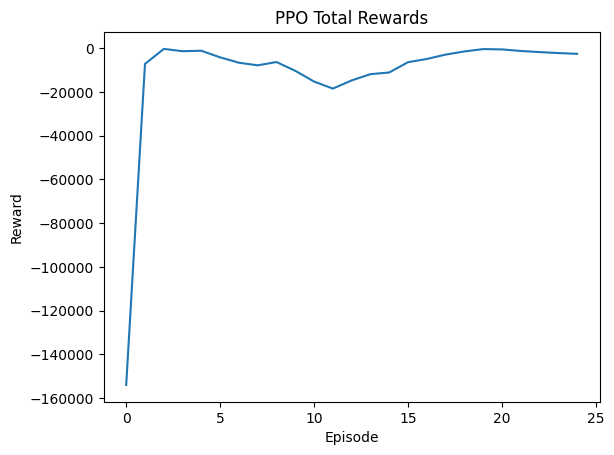

In [ ]:
plt.plot(episode_rewards_ppo)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('PPO Total Rewards')
plt.show()

[*********************100%%**********************]  1 of 1 completed


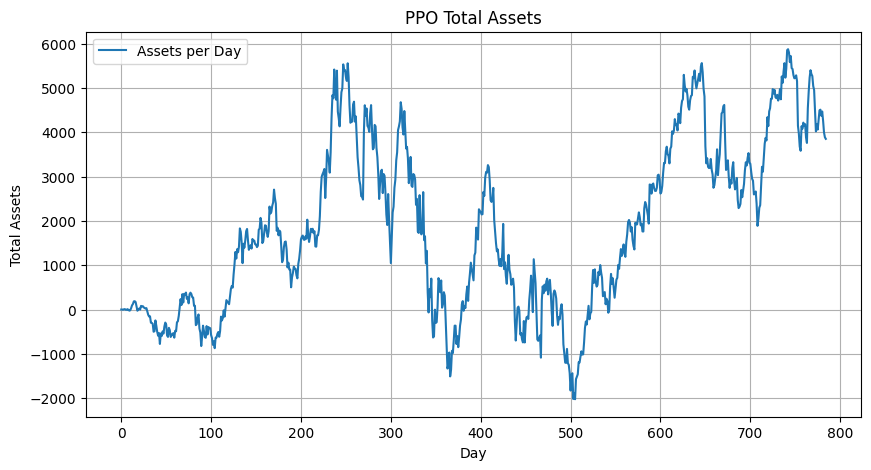

In [ ]:
def test_agent(env, agent, num_episodes=10):
    state = env.reset()
    done = False
    total_rewards = []
    assets = [env.total_asset]
    while not done:
        action, _, _ = agent.select_action(state)  # This uses the low epsilon to exploit the learned policy
        # print(action)
        state, reward, done = env.step(action)
        assets.append(env.total_asset)
        total_rewards.append(reward)
    return total_rewards, assets

# def test_agent(env, agent, num_episodes=10):
#     total_rewards = []
#     assets = []

#     for episode in range(num_episodes):
#         state = env.reset()
#         done = False
#         episode_assets = [env.total_asset]

#         while not done:
#             action, _, _ = agent.select_action(state)  # Assuming select_action returns the best action
#             state, reward, done = env.step(action)
#             episode_assets.append(env.total_asset)
#             total_rewards.append(reward)

#         assets.append(episode_assets[-1])  # Store assets for each episode

#     return total_rewards, assets


# Test the agent
ppo_test_env = StockTradingEnv('AAPL', start_date="2021-01-01", end_date="2024-03-01", window_size=10)
test_rewards, ppo_assets = test_agent(ppo_test_env, ppo_agent, num_episodes=10)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(ppo_assets, label='Assets per Day')
plt.title('PPO Total Assets')
plt.xlabel('Day')
plt.ylabel('Total Assets')
plt.grid(True)
plt.legend()
plt.show()

##Ensemble Agent

In [ ]:
class EnsembleAgent:
    def __init__(self, agents):
        self.agents = agents

    def convert_action(self, action):
      if action == 0:
        return 1
      elif action == 1:
        return 0
      elif action == 2:
        return -1


    def select_action(self, state):
        """Selects an action based on majority vote from all agents."""
        converted = []
        actions = []
        agent_weights = [0.2, 0.4, 0.1, 0.3]
        for idx, agent in enumerate(self.agents):
            if hasattr(agent, 'epsilon'):
              agent.epsilon = 0.0  # Freeze the agent's epsilon
            if hasattr(agent, 'get_action'):
              result = agent.get_action(state)
            else:
              result = agent.select_action(state)
            if isinstance(result, tuple):
                action = result[0]
            else:
                action = result

            actions.append(action)
            converted.append(self.convert_action(action))

        # Count the frequency of each action and return the most common
        # action_counts = np.bincount(actions)
        # most_common_action = np.argmax(action_counts)

        sum_actions = np.sum(converted)
        if sum_actions >= 1:
          most_common_action = 0
        elif sum_actions <= -1:
          most_common_action = 2
        else:
          most_common_action = 1

        return most_common_action


In [ ]:
# Assuming the environment, 'StockTradingEnv' for instance, is available
env = StockTradingEnv('AAPL', start_date="2021-01-01", end_date="2024-03-01", window_size=10)

ensemble_agent = EnsembleAgent([dqn_agent, ddpg_agent, a2c_agent, ppo_agent])

# Define a testing function
def test_ensemble_agent(env, agent, num_episodes=10):
    rewards = []
    assets = [env.initial_total_asset]
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.select_action(state)
        print(action)
        state, reward, done = env.step(action)
        assets.append(env.total_asset)
        rewards.append(reward)
        print(f'Total Reward = {reward}')
    return rewards, assets

# Test the agent
episode_rewards_ensemble, ensemble_assets = test_ensemble_agent(env, ensemble_agent, num_episodes=10)




[*********************100%%**********************]  1 of 1 completed


0
Total Reward = -14.619908167863315
0
Total Reward = 4.320717101231824
0
Total Reward = 0.17703370594612688
0
Total Reward = -6.457881567943057
0
Total Reward = -2.1148597401182614
0
Total Reward = 0.17428367277913798
0
Total Reward = -5.24095142977349
0
Total Reward = -5.274513133180001
0
Total Reward = -2.5681720852254766
0
Total Reward = 1.1550342902603958
0
Total Reward = 1.4170954918301852
0
Total Reward = -2.2315736608002648
2
Total Reward = -13.10040994757906
0
Total Reward = -4.7408349147364
0
Total Reward = -6.78777863170547
0
Total Reward = -31.350413491256244
2
Total Reward = 0.7864533651042879
2
Total Reward = -6.437882678760344
2
Total Reward = -5.322945025928305
0
Total Reward = -5.990993039662989
2
Total Reward = -10.561053498599607
0
Total Reward = -5.312539631609366
0
Total Reward = -5.016253287581552
0
Total Reward = -6.678364376643199
0
Total Reward = -6.6971374479308965
2
Total Reward = -5.231148644017784
0
Total Reward = -5.638463233617555
0
Total Reward = -9.1944

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


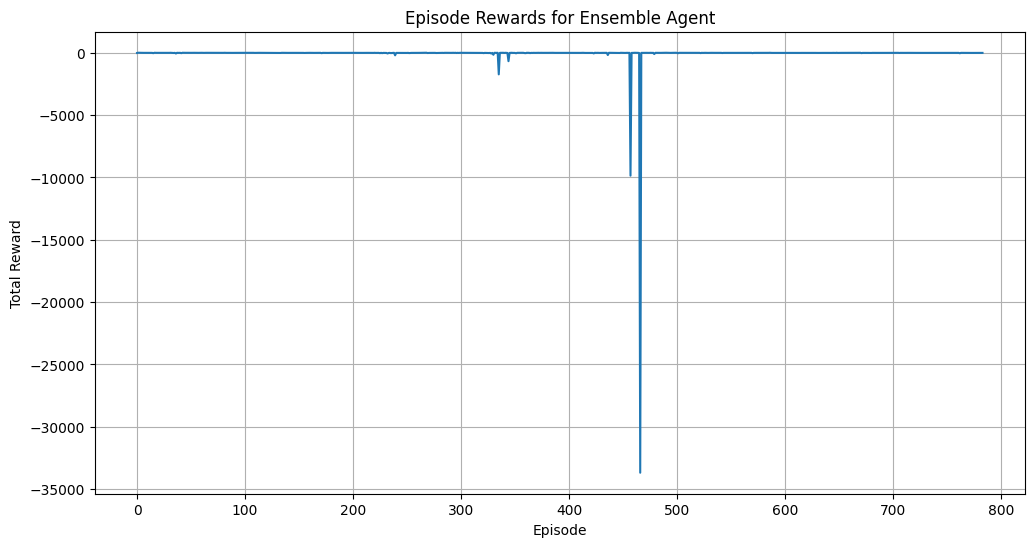

In [ ]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(episode_rewards_ensemble, label='Ensemble Agent')
plt.title('Episode Rewards for Ensemble Agent')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

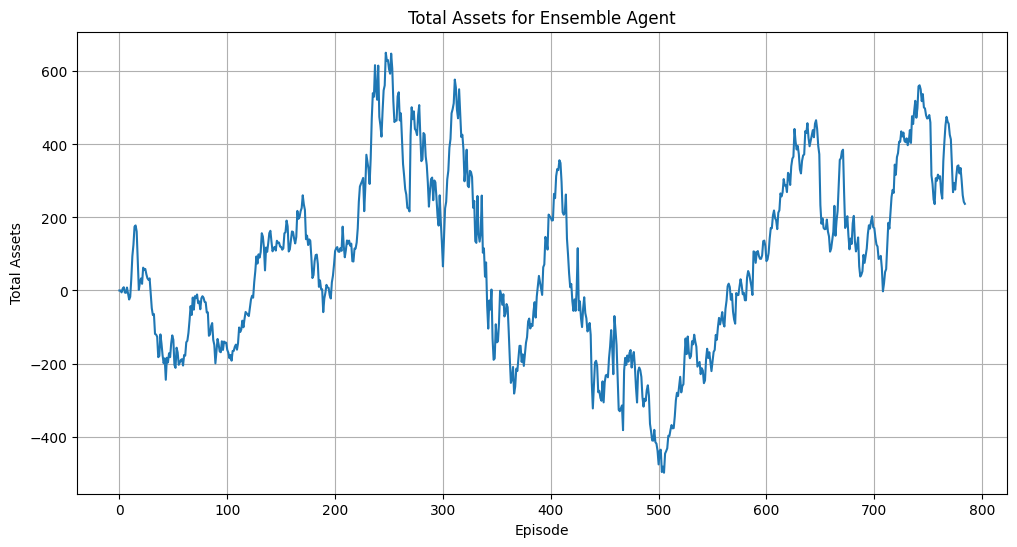

In [ ]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(ensemble_assets, label='Ensemble Agent')
plt.title('Total Assets for Ensemble Agent')
plt.xlabel('Episode')
plt.ylabel('Total Assets')
plt.grid(True)
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


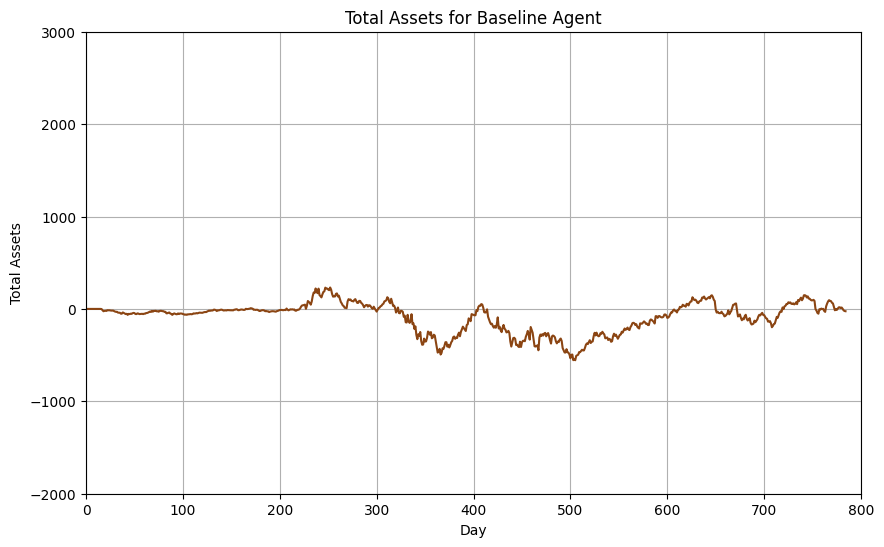

In [ ]:
def trading_strategy(prices):
    """
    Determines trading actions based on consecutive days of price increases or decreases.

    Args:
    prices (list): A list of stock prices (floats).

    Returns:
    list: A list of trading actions (0: Buy, 1: Hold, 2: Sell) for each day.
    """
    n = len(prices)
    actions = [1 for i in range(len(prices))] # Initialize all actions to 'Hold' (1)

    if n < 5:
        return actions  # Not enough data to apply the strategy

    # Check for five consecutive increases or decreases
    for i in range(4, n):
        if all(prices[j] > prices[j - 1] for j in range(i - 4, i + 1)):
            actions[i] = 0  # Buy
        elif all(prices[j] < prices[j - 1] for j in range(i - 4, i + 1)):
            actions[i] = 2  # Sell

    return actions


env = StockTradingEnv("AAPL", start_date="2021-01-01", end_date="2024-03-01", window_size=10)
data = get_data("AAPL", start_date="2021-01-01", end_date="2024-03-01")
prices = data["CPI_Adjusted_Price"].tolist()
actions = trading_strategy(prices)
# print(actions)

def generate_baseline(env, actions, num_episodes=10):
    rewards = []
    assets = [env.initial_total_asset]
    state = env.reset()
    total_reward = 0
    done = False
    count = 0
    while not done:
        state, reward, done = env.step(actions[count])
        assets.append(env.total_asset)
        rewards.append(reward)
        # print(f'Total Reward = {reward}')
        count += 1
    return rewards, assets

# Test the agent
baseline_ensemble, baseline_assets = generate_baseline(env, actions, num_episodes=10)
plt.figure(figsize=(10, 6))
plt.ylim(-2000, 3000)  # Setting the x-axis limits
plt.xlim(0, 800)  # Setting the y-axis limits
plt.plot(baseline_assets, label='Baseline Agent', color="saddlebrown")
plt.title('Total Assets for Baseline Agent')
plt.xlabel('Day')
plt.ylabel('Total Assets')
plt.grid(True)



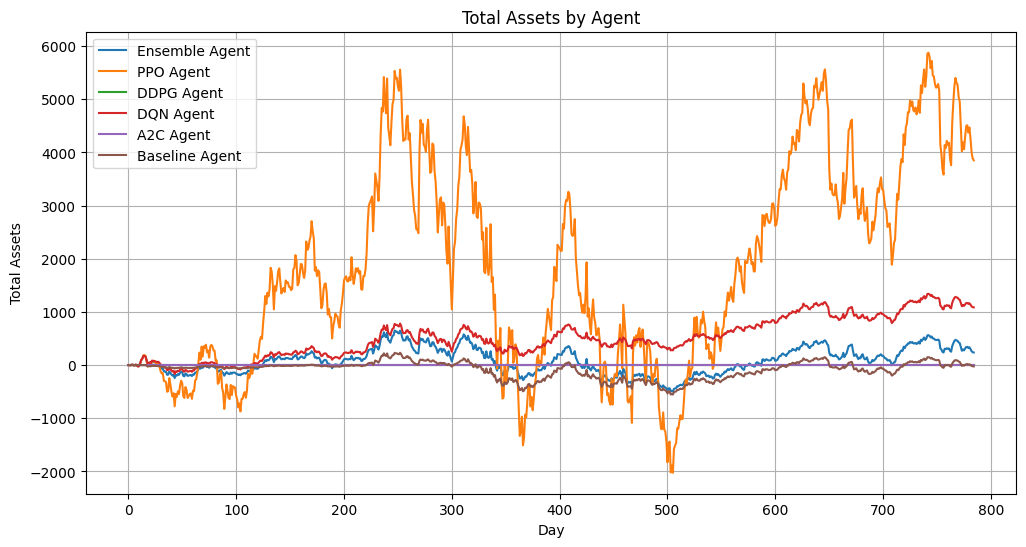

In [ ]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(ensemble_assets, label='Ensemble Agent')
plt.plot(ppo_assets, label='PPO Agent')
plt.plot(ddpg_assets, label='DDPG Agent')
plt.plot(dqn_assets, label='DQN Agent')
plt.plot(a2c_assets, label='A2C Agent')
plt.plot(baseline_assets, label='Baseline Agent')
plt.title('Total Assets by Agent')
plt.xlabel('Day')
plt.ylabel('Total Assets')
plt.legend()
plt.grid(True)
plt.show()

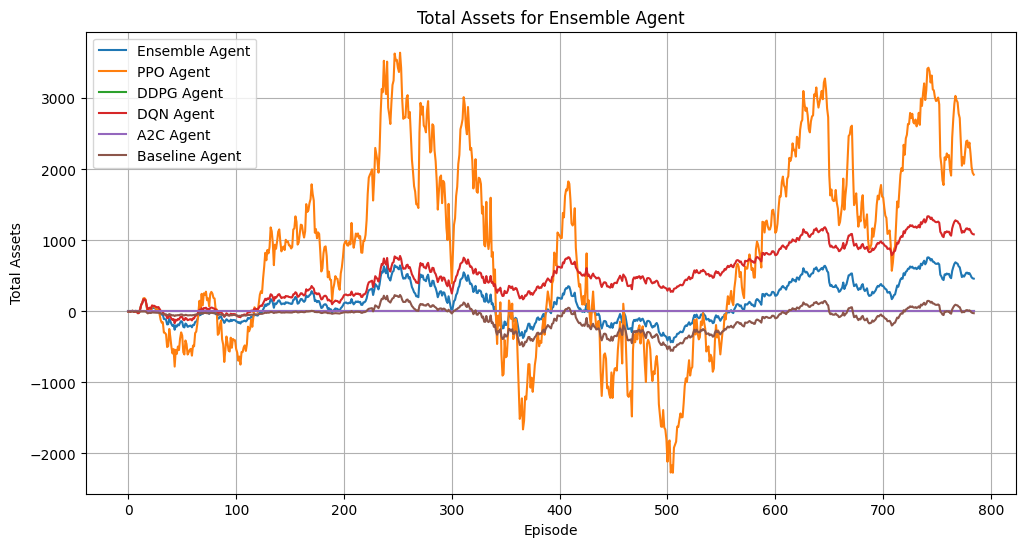